In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dropout


# Add src to path so we can import our custom modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from preprocessing import TweetCleaner
from data_loader import DataLoader

# Visualization Style
sns.set_style('whitegrid')
%matplotlib inline

**Load and Clean data**

In [2]:
# Load the file directly to check headers
vix_test = pd.read_csv('../data/raw/vix_data.csv')
print("Columns found:", vix_test.columns.tolist())

Columns found: ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']


In [3]:
# 1. Initialize Loader
loader = DataLoader(
    tweets_path='../data/raw/trump_tweets.csv',
    vix_path='../data/raw/vix_data.csv'
)

# 2. Load and Clean Tweets (this takes a moment)
cleaner = TweetCleaner()
raw_tweets = pd.read_csv(loader.tweets_path)
clean_tweets = cleaner.preprocess_dataframe(raw_tweets, text_column='content')

# 3. Merge with VIX
# (This step aligns the dates using the logic in src/data_loader.py)
df = loader.merge_data(clean_tweets)

print(f"✅ Data Ready! Final Dataset shape: {df.shape}")
df.head(3)

Cleaning 43352 tweets and tagging expanded topics...
Loading VIX from: ../data/raw/vix_data.csv
Merging datasets...
Merge Complete. Shape: (33669, 18)
✅ Data Ready! Final Dataset shape: (33669, 18)


c:\AI_Workspace\AI_Datasets\Trump-Markets-Volatility\src\data_loader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['date'] = pd.to_datetime(pd.to_datetime(df_tweets['date']).dt.date)


,id,link,content,date,retweets,favorites,mentions,hashtags,cleaned_text,tweet_length,is_economy,is_geo,is_domestic,is_corporate,is_other,Date,Close,target_value
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04,510,917,NaN,NaN,be sure to tune in and watch donald trump on l...,116,0,0,0,0,1,2009-05-04,34.53,33.36
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04,34,267,NaN,NaN,donald trump will be appearing on the view tom...,130,0,0,1,0,0,2009-05-04,34.53,33.36
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08,13,19,NaN,NaN,donald trump reads top ten financial tips on l...,86,0,0,0,0,1,2009-05-08,32.05,32.87


**Feature Engineering (Preparing X and y)**
For the "Baseline" model, we will just use simple numerical features (Sentiment & Volume) instead of complex text embeddings, to prove the concept first.

In [4]:
# Create Aggregated Features (Now with 5 Topics!)
daily_data = df.groupby('date').agg({
    'tweet_length': ['mean', 'count'],  # Volume & Intensity
    'is_economy': 'sum',                # Count of Econ tweets
    'is_geo': 'sum',                    # Count of War/Geopolitics tweets
    'is_domestic': 'sum',               # Count of ICE/Election/Border tweets
    'is_corporate': 'sum',              # Count of Company/Media attacks
    'is_other': 'sum',                  # Count of everything else
    'Close': 'first',                   
    'target_value': 'first'             
}).reset_index()

# Flatten columns
daily_data.columns = [
    'date', 'avg_len', 'tweet_count', 
    'econ_count', 'geo_count', 'dom_count', 'corp_count', 'other_count', 
    'vix_today', 'vix_tomorrow'
]

# Define Features (X) - We now have 8 inputs!
features = [
    'avg_len', 'tweet_count', 
    'econ_count', 'geo_count', 'dom_count', 'corp_count', 'other_count', 
    'vix_today'
]

print(f"Using Features: {features}")

X = daily_data[features].values
y = (daily_data['vix_tomorrow'] > daily_data['vix_today']).astype(int)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features Prepared. Input Shape: {X_train.shape}")

Using Features: ['avg_len', 'tweet_count', 'econ_count', 'geo_count', 'dom_count', 'corp_count', 'other_count', 'vix_today']
Features Prepared. Input Shape: (1967, 8)


**Model 1 - The Baseline (Simple Dense Network)**

In [5]:
def build_baseline_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid') # Binary Output (Up/Down)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_1 = build_baseline_model()
# 1. Define the "Safety Brake"
early_stopper = EarlyStopping(
    monitor='val_loss',         # Watch the error rate
    patience=5,                 # If it gets worse for 5 epochs...
    restore_best_weights=True,  # ...STOP and go back to the best version (Epoch 5)
    verbose=1
)

# 2. Train with the callback
history_1 = model_1.fit(
    X_train_scaled, y_train, 
    epochs=50,                  # Set this high (it will stop automatically)
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopper],  # <--- This is the key!
    verbose=1
)
    
# 3. Evaluate the "Best" Version
print(f"✅ Final Optimized Accuracy for model_1: {model_1.evaluate(X_test_scaled, y_test)[1]:.4f}")
# ==========================================

Epoch 1/50


C:\Users\dario\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4971 - loss: 0.7065 - val_accuracy: 0.5254 - val_loss: 0.6956
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - loss: 0.6973 - val_accuracy: 0.5127 - val_loss: 0.6934
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.6928 - val_accuracy: 0.5254 - val_loss: 0.6916
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5474 - loss: 0.6902 - val_accuracy: 0.5279 - val_loss: 0.6908
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5480 - loss: 0.6876 - val_accuracy: 0.5152 - val_loss: 0.6914
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5531 - loss: 0.6864 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5613 - loss: 0.6849 - val_accuracy: 0.4975 - val_loss: 0.6945
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5620 - loss: 0.6837 - val_accuracy: 0.4975 - val_loss: 0.6946
Epo

**Model 2 - The "Deep" Model (More Layers)**

In [6]:
def build_deep_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_2 = build_deep_model()
# 1. Define the "Safety Brake"
early_stopper = EarlyStopping(
    monitor='val_loss',         # Watch the error rate
    patience=5,                 # If it gets worse for 5 epochs...
    restore_best_weights=True,  # ...STOP and go back to the best version (Epoch 5)
    verbose=1
)

# 2. Train with the callback
history_2 = model_2.fit(
    X_train_scaled, y_train, 
    epochs=50,                  # Set this high (it will stop automatically)
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopper],  # <--- This is the key!
    verbose=1
)

# 3. Evaluate the "Best" Version
print(f"✅ Final Optimized Accuracy for Model 2: {model_2.evaluate(X_test_scaled, y_test)[1]:.4f}")


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5289 - loss: 0.6957 - val_accuracy: 0.5355 - val_loss: 0.6889
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5518 - loss: 0.6872 - val_accuracy: 0.5305 - val_loss: 0.6896
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5607 - loss: 0.6844 - val_accuracy: 0.5508 - val_loss: 0.6887
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5690 - loss: 0.6814 - val_accuracy: 0.5076 - val_loss: 0.6917
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5690 - loss: 0.6796 - val_accuracy: 0.5025 - val_loss: 0.6955
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5817 - loss: 0.6782 - val_accuracy: 0.5051 - val_loss: 0.6952
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5696 - loss: 0.6753 - val_accuracy: 0.4797 - val_loss: 0.7012
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5823 - loss: 0.6737 - val_accuracy: 0.4569 - val_loss:

**Model 3 - Regularized (To Prevent Overfitting)**

In [7]:
def build_regularized_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),  # Drop 30% of neurons to prevent memorization
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


model_3 = build_regularized_model()

# 1. Define the "Safety Brake"
early_stopper = EarlyStopping(
    monitor='val_loss',         # Watch the error rate
    patience=5,                 # If it gets worse for 5 epochs...
    restore_best_weights=True,  # ...STOP and go back to the best version (Epoch 5)
    verbose=1
)

# 2. Train with the callback
history_3 = model_3.fit(
    X_train_scaled, y_train, 
    epochs=50,                  # Set this high (it will stop automatically)
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopper],  # <--- This is the key!
    verbose=1
)

# 3. Evaluate the "Best" Version
print(f"✅ Final Optimized Accuracy: {model_3.evaluate(X_test_scaled, y_test)[1]:.4f}")


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5137 - loss: 0.7121 - val_accuracy: 0.5330 - val_loss: 0.6939
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5486 - loss: 0.6885 - val_accuracy: 0.5203 - val_loss: 0.6922
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5366 - loss: 0.6945 - val_accuracy: 0.5203 - val_loss: 0.6928
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5588 - loss: 0.6859 - val_accuracy: 0.5102 - val_loss: 0.6907
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5512 - loss: 0.6861 - val_accuracy: 0.5431 - val_loss: 0.6921
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5588 - loss: 0.6841 - val_accuracy: 0.5305 - val_loss: 0.6918
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5474 - loss: 0.6854 - val_accuracy: 0.4822 - val_loss: 0.6958
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5645 - loss: 0.6822 - val_accuracy: 0.4848 - val_loss:

**Plot comparison**

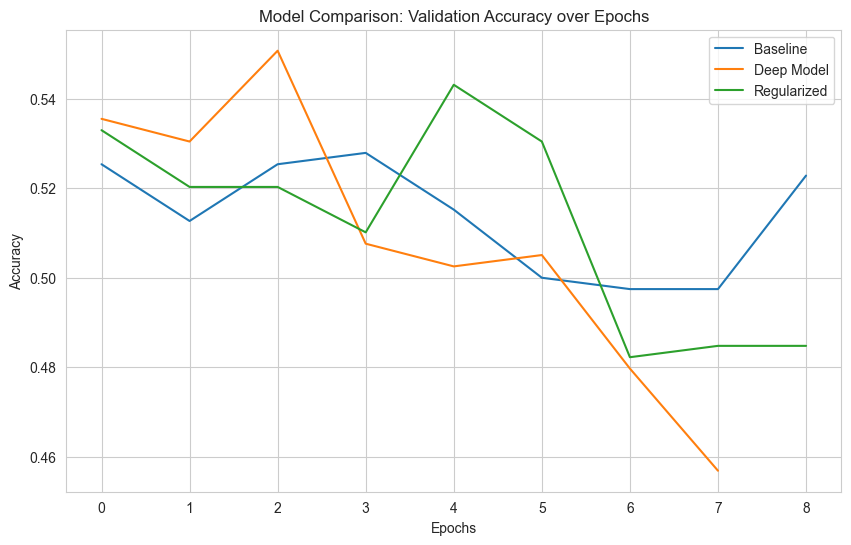

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['val_accuracy'], label='Baseline')
plt.plot(history_2.history['val_accuracy'], label='Deep Model')
plt.plot(history_3.history['val_accuracy'], label='Regularized')
plt.title('Model Comparison: Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**LSTM**

In [9]:
import numpy as np
from tensorflow.keras.layers import LSTM

# ==========================================
# 1. PREPARE DATA FOR LSTM (3D Sliding Window)
# ==========================================
def create_sequences(X, y, time_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        # Take a "window" of 'time_steps' days
        Xs.append(X[i:(i + time_steps)])
        # Target is the label for the day AFTER the window
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define how many days back the model should look (Memory)
TIME_STEPS = 2  

# We use the scaled data we already created (X_scaled)
# But first, we need to combine Train+Test back together to sequence them properly
X_all_scaled = np.vstack((X_train_scaled, X_test_scaled))
y_all = np.hstack((y_train, y_test))

# Create the 3D Sequences
X_lstm, y_lstm = create_sequences(X_all_scaled, y_all, time_steps=TIME_STEPS)

# Split into Train/Test again (keeping order is crucial for time series!)
split_idx = int(len(X_lstm) * 0.8)

X_train_lstm = X_lstm[:split_idx]
X_test_lstm  = X_lstm[split_idx:]
y_train_lstm = y_lstm[:split_idx]
y_test_lstm  = y_lstm[split_idx:]

print(f"LSTM Data Shape: {X_train_lstm.shape}") 
# Should look like: (Samples, 3, 8) -> (Rows, Days to look back, Features)

# ==========================================
# 2. BUILD THE LSTM MODEL
# ==========================================
model_lstm = Sequential([
    # Input shape is (Time_Steps, Features)
    LSTM(50, return_sequences=False, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),
    Dropout(0.2), # Prevent overfitting
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ==========================================
# 3. TRAIN AND EVALUATE
# ==========================================
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True)


print("\nTraining LSTM Model...")
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stop], 
    verbose=1
)

print(f"✅ LSTM Model Accuracy: {model_lstm.evaluate(X_test_lstm, y_test_lstm)[1]:.4f}")

LSTM Data Shape: (1965, 2, 8)

Training LSTM Model...
Epoch 1/50


C:\Users\dario\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5426 - loss: 0.6897 - val_accuracy: 0.5038 - val_loss: 0.6887
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5420 - loss: 0.6869 - val_accuracy: 0.4987 - val_loss: 0.6877
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5496 - loss: 0.6858 - val_accuracy: 0.5140 - val_loss: 0.6880
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5585 - loss: 0.6842 - val_accuracy: 0.5242 - val_loss: 0.6883
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5560 - loss: 0.6845 - val_accuracy: 0.5318 - val_loss: 0.6890
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5630 - loss: 0.6833 - val_accuracy: 0.5216 - val_loss: 0.6904
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5592 - loss: 0.6828 - val_accuracy: 0.5191 - val_loss: 0.6907
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5589 - loss: 0.6835 
✅ LSTM Model Accuracy: 0.5589


In [10]:
# 1. Get predictions from Model 1 (Dense)
# (Reshape X_test_lstm back to 2D for the Dense model)
X_test_dense_input = X_test_lstm[:, -1, :] # Take only the last day's data
pred_dense = model_1.predict(X_test_dense_input)

# 2. Get predictions from Model 4 (LSTM)
pred_lstm = model_lstm.predict(X_test_lstm)

# 3. Average them (Ensemble)
final_pred_prob = (pred_dense + pred_lstm) / 2
final_pred_class = (final_pred_prob > 0.5).astype(int)

# 4. Check Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_lstm, final_pred_class)
print(f"🚀 Ensemble Model Accuracy: {acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
🚀 Ensemble Model Accuracy: 0.5752


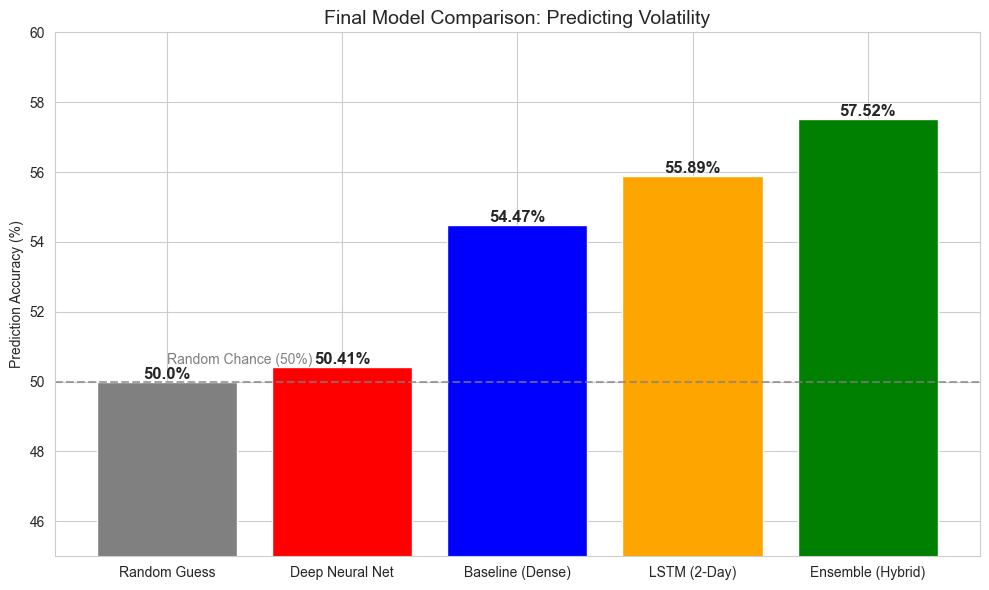

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your final run
models = ['Random Guess', 'Deep Neural Net', 'Baseline (Dense)', 'LSTM (2-Day)', 'Ensemble (Hybrid)']
accuracies = [50.00, 50.41, 54.47, 55.89, 57.52]
colors = ['gray', 'red', 'blue', 'orange', 'green']

plt.figure(figsize=(10, 6))
# Create bar chart
bars = plt.bar(models, accuracies, color=colors)

# Add a horizontal line for Random Guess
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
plt.text(0, 50.5, 'Random Chance (50%)', color='gray')

# Label the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(45, 60)
plt.ylabel('Prediction Accuracy (%)')
plt.title('Final Model Comparison: Predicting Volatility', fontsize=14)
plt.tight_layout()

# Save for your report
plt.savefig('final_model_results.png')
plt.show()